In [113]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
from tqdm import tqdm
from datetime import datetime


import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import copy

In [114]:
print("CUDA available:", torch.cuda.is_available())  
print("CUDA version:", torch.version.cuda)          
print("Device:", torch.device("cuda"))             
print("GPU name:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA available: True
CUDA version: 13.0
Device: cuda
GPU name: NVIDIA GeForce RTX 3060


In [115]:
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])
dataset = datasets.ImageFolder(root='Faulty_solar_panel', transform=transform)
print("Dataset size:", len(dataset))
print("Classes:", dataset.classes)
num_classes = len(dataset.classes)


Dataset size: 1207
Classes: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


In [116]:
orig_indices = []
aug_indices = []

for idx, (path, _) in enumerate(dataset.samples):
    filename = os.path.basename(path)
    if filename.startswith("aug_"):
        aug_indices.append(idx)
    else:
        orig_indices.append(idx)

print("Original Count:", len(orig_indices))
print("Augmented Count:", len(aug_indices))

orig_by_class = {i: [] for i in range(len(dataset.classes))}
aug_by_class = {i: [] for i in range(len(dataset.classes))}

for idx in orig_indices:
    orig_by_class[dataset.targets[idx]].append(idx)
for idx in aug_indices:
    aug_by_class[dataset.targets[idx]].append(idx)

final_train_indices = []
final_val_indices = []
final_test_indices = []

test_size = int(0.05 * (len(dataset)/len(dataset.classes)))
val_size = int(0.15 * (len(dataset)/len(dataset.classes)))
print("Test size (5%):", test_size)
print("Validation size (15%):", val_size)

np.random.seed(67)
for label in range(len(dataset.classes)):
    origs = orig_by_class[label]
    np.random.shuffle(origs)
    
    final_test_indices.extend(origs[:test_size])
    final_val_indices.extend(origs[test_size:test_size+val_size])
    
   
    train_pool = origs[test_size+val_size:] + aug_by_class[label]
    final_train_indices.append(train_pool)

min_train_size = min(len(p) for p in final_train_indices)

balanced_train_indices = []
for pool in final_train_indices:
    balanced_train_indices.extend(pool[:min_train_size])

train_ds = Subset(dataset, balanced_train_indices)
val_ds   = Subset(dataset, final_val_indices)
test_ds  = Subset(dataset, final_test_indices)


print(f"Test size:{len(test_ds)}  ({test_size} per class, not augmented)")
print(f"Val: {len(val_ds)} ({val_size} per class, not augmented)")
print(f"Train: {len(train_ds)} ({min_train_size} per class, both)")


Original Count: 885
Augmented Count: 322
Test size (5%): 10
Validation size (15%): 30
Test size:60  (10 per class, not augmented)
Val: 180 (30 per class, not augmented)
Train: 960 (160 per class, both)


In [ ]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True, num_workers=8,drop_last=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, pin_memory=True, num_workers=8, drop_last=True)
#test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, pin_memory=True, num_workers=8, drop_last=True)

In [155]:
test_loader = DataLoader(test_ds, batch_size=32, shuffle=True, pin_memory=True, num_workers=8)

In [118]:
def create_Autoencoder():
    class Autoencoder(nn.Module):
        def __init__(self):
            super(Autoencoder, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 16, 3, stride=2, padding=1),  # [3,256,256] -> [16,128,128]
                nn.ReLU(),
                nn.Conv2d(16,32,3,stride=2,padding=1),    # [16,128,128] -> [32,64,64]
                nn.ReLU(),
                nn.Conv2d(32,64,3,stride=2,padding=1),    # [32,64,64] -> [64,32,32]
                nn.ReLU(),
                nn.Conv2d(64,128,3,stride=2,padding=1),   # [64,32,32] -> [128,16,16]
                nn.ReLU(),
                nn.Conv2d(128,256,3,stride=2,padding=1),   # [64,32,32] -> [128,16,16]
                nn.ReLU()
            )
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(256,128,3,stride=2,padding=1,output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(128,64,3,stride=2,padding=1,output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(64,32,3,stride=2,padding=1,output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(32,16,3,stride=2,padding=1,output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(16,3,3,stride=2,padding=1,output_padding=1),
                nn.Sigmoid()
            )

        def forward(self,x):
            latent = self.encoder(x)
            recon = self.decoder(latent)
            return recon

    autoencoder = Autoencoder().to(device)
    ae_lossfun = nn.MSELoss()
    ae_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
    return autoencoder, ae_lossfun, ae_optimizer


In [119]:
def create_ImprovedAutoencoder():
    class ImprovedAutoencoder(nn.Module):
        def __init__(self):
            super(ImprovedAutoencoder, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, 3, stride=2, padding=1),  
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(32,64,3,stride=2,padding=1),    
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(64,128,3,stride=2,padding=1),    
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(128,256,3,stride=2,padding=1),   
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(256,512,3,stride=2,padding=1), 
                nn.BatchNorm2d(512),
                nn.LeakyReLU(0.2, inplace=True)
            )
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(512,256,3,stride=2,padding=1,output_padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.ConvTranspose2d(256,128,3,stride=2,padding=1,output_padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.ConvTranspose2d(128,64,3,stride=2,padding=1,output_padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.ConvTranspose2d(64,32,3,stride=2,padding=1,output_padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.ConvTranspose2d(32,3,3,stride=2,padding=1,output_padding=1),
                nn.Tanh()
            )

        def forward(self,x):
            latent = self.encoder(x)
            recon = self.decoder(latent)
            return recon
    
    autoencoder = ImprovedAutoencoder().to(device)
    ae_lossfun = nn.MSELoss()
    ae_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
    return autoencoder, ae_lossfun, ae_optimizer


In [120]:
def train_autoencoder(autoencoder, ae_lossfun, ae_optimizer, num_ae_epochs=40):
    ae_losses = torch.zeros(num_ae_epochs)

    for epoch in range(num_ae_epochs):
        batchLoss = []
        for images, _ in train_loader:
            images = images.to(device)
            outputs = autoencoder(images)
            loss = ae_lossfun(outputs, images)

            ae_optimizer.zero_grad()
            loss.backward()
            ae_optimizer.step()

            batchLoss.append(loss.item())

        epoch_loss = sum(batchLoss) / len(batchLoss)
        ae_losses[epoch] = epoch_loss
        if(epoch % 2 == 0):
            print(f"AE Epoch [{epoch+1}/{num_ae_epochs}], Loss: {epoch_loss:.6f}")

    print(f"Final loss: {ae_losses[-1]:.6f}")
    return ae_losses, autoencoder

In [121]:
autoencoder, lossfun, optimizer = create_Autoencoder()
num_epochs = 10
ae_losses, trained_autoencoder = train_autoencoder(autoencoder, lossfun, optimizer, num_ae_epochs=num_epochs)


AE Epoch [1/10], Loss: 0.477275
AE Epoch [3/10], Loss: 0.214797
AE Epoch [5/10], Loss: 0.201569
AE Epoch [7/10], Loss: 0.196986
AE Epoch [9/10], Loss: 0.194699
Final loss: 0.193549


In [122]:
iae, iae_lossfun, iae_optimizer = create_ImprovedAutoencoder()
num_epochs = 10
iae_losses, trained_iae = train_autoencoder(iae, iae_lossfun, iae_optimizer, num_ae_epochs=num_epochs)

AE Epoch [1/10], Loss: 0.191825
AE Epoch [3/10], Loss: 0.067592
AE Epoch [5/10], Loss: 0.059088
AE Epoch [7/10], Loss: 0.051382
AE Epoch [9/10], Loss: 0.047106
Final loss: 0.042286


In [123]:
def plot_ae_losses(ae_losses, num_epochs):
    fig,ax = plt.subplots(1,1,figsize=(7,5))
    ax.plot(ae_losses.cpu().numpy())
    ax.set_xticks(np.arange(0, num_epochs, 1))
    ax.set_xlabel('Epochs')
    ax.set_title('Autoencoder Training Loss')
    ax.set_ylabel('Loss')
    ax.set_xlim([0,num_epochs-1])
    plt.show()

In [124]:
def show_sample_reconstructions(autoencoder):
    with torch.no_grad():
        images, _ = random.choice(list(test_loader))
        images = images.to(device)
        outputs = autoencoder(images)
        
        images = images.cpu()
        outputs = outputs.cpu()

    num_images = 5
    plt.figure(figsize=(12, 4))
    for i in range(num_images):

        plt.subplot(2, num_images, i+1)
        plt.imshow(images[i].permute(1,2,0).numpy())
        plt.title("Original")
        plt.axis("off")


        plt.subplot(2, num_images, i+1+num_images)
        plt.imshow(outputs[i].permute(1,2,0).numpy())
        plt.title("Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

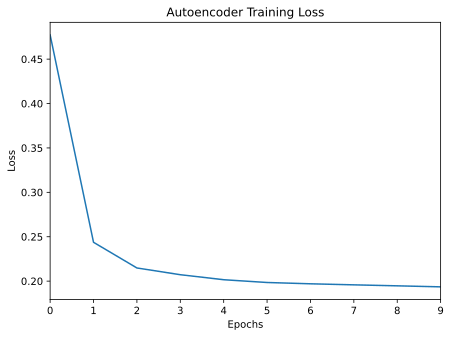

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000174186FC9D0>
Traceback (most recent call last):
  File "d:\2mag\ASI\sp_issues_detector\.venv\lib\site-packages\torch\utils\data\dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "d:\2mag\ASI\sp_issues_detector\.

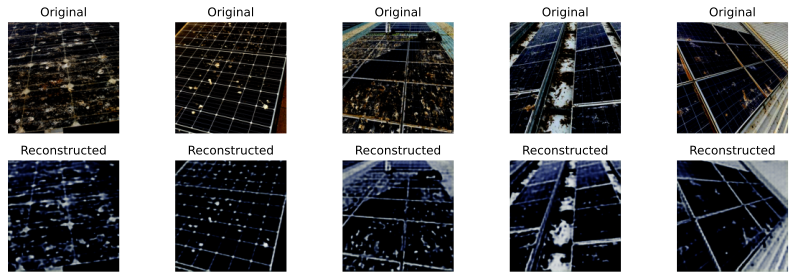

In [125]:
# Show loss and sample reconstructions for basic autoencoder
plot_ae_losses(ae_losses, num_epochs)   
show_sample_reconstructions(trained_autoencoder)

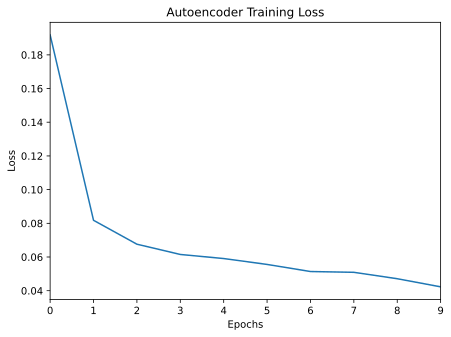

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9572723..0.95072156].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79556936..0.9876311].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372275..0.97844154].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping in

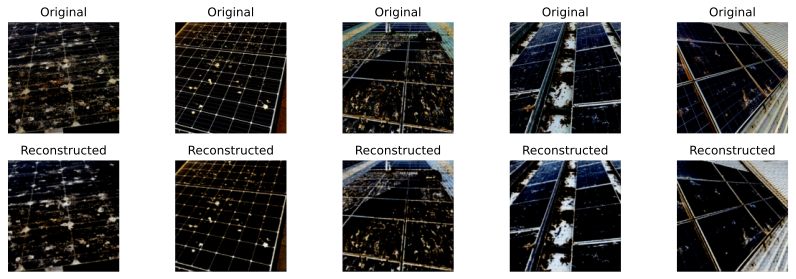

In [126]:
#Show loss and sample reconstructions for improved autoencoder
plot_ae_losses(iae_losses, num_epochs)
show_sample_reconstructions(trained_iae)

In [127]:
def create_Classifier(latent_channels):
    class Classifier(nn.Module):
        def __init__(self, latent_channels, num_classes=6):
            super(Classifier, self).__init__()
            self.pool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Sequential(
                nn.Flatten(),
                nn.Linear(latent_channels, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512,256),
                nn.ReLU(inplace=True),
                nn.Linear(256,128),
                nn.ReLU(inplace=True),
                nn.Linear(128,64),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                nn.Linear(64, num_classes)
            )
        def forward(self,x):
            x = self.pool(x)
            x = self.fc(x)
            return x

    classifier = Classifier(latent_channels=latent_channels, num_classes=num_classes).to(device)
    clf_lossfun = nn.CrossEntropyLoss()
    clf_optimizer = optim.Adam(classifier.parameters(), lr=1e-4)
    return classifier, clf_lossfun, clf_optimizer

In [128]:
def create_ImprovedClassifier(latent_channels):
    class ImprovedClassifier(nn.Module):
        def __init__(self, latent_channels, num_classes=6):
            super(ImprovedClassifier, self).__init__()
            self.pool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Sequential(
                nn.Flatten(),
                nn.Linear(latent_channels, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(inplace=True),
                
                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),

                nn.Linear(256, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                
                nn.Linear(128, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),

                nn.Linear(64, num_classes)
            )
        def forward(self,x):
            x = self.pool(x)
            x = self.fc(x)
            return x

    classifier = ImprovedClassifier(latent_channels=latent_channels, num_classes=num_classes).to(device)
    clf_lossfun = nn.CrossEntropyLoss()
    clf_optimizer = optim.Adam(classifier.parameters(), lr=1e-4)
    return classifier, clf_lossfun, clf_optimizer

In [129]:
def train_net(autoencoder,classifier,lossfun,optimizer,num_epochs=100):
    for param in autoencoder.encoder.parameters():
        param.requires_grad = True
    
    print("Training classifier with encoder fine-tuning...")
    losses = torch.zeros(num_epochs)
    train_acc  = []
    val_acc = []
    for epoch in range(num_epochs):
        batch_acc  = []
        batch_loss = []
        
        autoencoder.encoder.train()
        classifier.train()
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            latent = autoencoder.encoder(images)
            outputs = classifier(latent)
            loss = lossfun(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())
            batch_acc.append(100*torch.mean((torch.argmax(outputs,axis=1) == labels).float()).item())

        train_acc.append(np.mean(batch_acc))
        losses[epoch] = np.mean(batch_loss)
        
        autoencoder.encoder.eval()
        classifier.eval()
        val_batch_acc = []
        for images_val, labels_val in val_loader:
            
            with torch.no_grad():
                images_val, labels_val = images_val.to(device), labels_val.to(device)
                latent_val = autoencoder.encoder(images_val)
                outputs_val = classifier(latent_val)
                val_batch_acc.append(100*torch.mean((torch.argmax(outputs_val,axis=1)==labels_val).float()).item())
        
        val_acc.append(np.mean(val_batch_acc))
        if(epoch % 10 == 0):
            print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {losses[epoch]:.4f}, Train Accuracy: {train_acc[epoch]:.2f}%, Validation Accuracy: {val_acc[epoch]:.2f}%")

    print(f"Final Loss: {losses[-1]:.4f}, Final Train Accuracy: {train_acc[-1]:.2f}%, Final Validation Accuracy: {val_acc[-1]:.2f}%")
    return losses, train_acc, val_acc, autoencoder, classifier

In [130]:
copy_trained_autoencoder_1 = copy.deepcopy(trained_autoencoder)
copy_trained_autoencoder_2 = copy.deepcopy(trained_autoencoder)
copy_trained_iae_1 = copy.deepcopy(trained_iae)
copy_trained_iae_2 = copy.deepcopy(trained_iae)


In [131]:
#AA - basic autoencoder + classifier
#BA - improved autoencoder + classifier
#AB - basic autoencoder + improved classifier
#BB - improved autoencoder + improved classifier
classifier, clf_lossfun, clf_optimizer = create_Classifier(latent_channels=256)
losses_AA, train_acc_AA, val_acc_AA, ae_AA, clf_AA = train_net(
    copy_trained_autoencoder_1, classifier, clf_lossfun, clf_optimizer, num_epochs=200
)

classifier, clf_lossfun, clf_optimizer = create_Classifier(latent_channels=512)
losses_BA, train_acc_BA, val_acc_BA, ae_BA, clf_BA = train_net(
    copy_trained_iae_1, classifier, clf_lossfun, clf_optimizer, num_epochs=200
)

improved_classifier, imp_clf_lossfun, imp_clf_optimizer = create_ImprovedClassifier(latent_channels=256)
losses_AB, train_acc_AB, val_acc_AB, ae_AB, clf_AB = train_net(
    copy_trained_autoencoder_2, improved_classifier, imp_clf_lossfun, imp_clf_optimizer, num_epochs=200
)

improved_classifier, imp_clf_lossfun, imp_clf_optimizer = create_ImprovedClassifier(latent_channels=512)
losses_BB, train_acc_BB, val_acc_BB, ae_BB, clf_BB = train_net(
    copy_trained_iae_2, improved_classifier, imp_clf_lossfun, imp_clf_optimizer, num_epochs=200
)

Training classifier with encoder fine-tuning...
Epoch [1/200] Loss: 1.7978, Train Accuracy: 19.48%, Validation Accuracy: 19.38%
Epoch [11/200] Loss: 1.6843, Train Accuracy: 27.50%, Validation Accuracy: 23.75%
Epoch [21/200] Loss: 1.6386, Train Accuracy: 31.56%, Validation Accuracy: 32.50%
Epoch [31/200] Loss: 1.5941, Train Accuracy: 33.85%, Validation Accuracy: 21.25%
Epoch [41/200] Loss: 1.6046, Train Accuracy: 33.33%, Validation Accuracy: 23.12%
Epoch [51/200] Loss: 1.5824, Train Accuracy: 36.25%, Validation Accuracy: 26.88%
Epoch [61/200] Loss: 1.5517, Train Accuracy: 35.62%, Validation Accuracy: 26.25%
Epoch [71/200] Loss: 1.5251, Train Accuracy: 38.54%, Validation Accuracy: 31.25%
Epoch [81/200] Loss: 1.4902, Train Accuracy: 41.35%, Validation Accuracy: 30.00%
Epoch [91/200] Loss: 1.4828, Train Accuracy: 40.31%, Validation Accuracy: 30.62%
Epoch [101/200] Loss: 1.4669, Train Accuracy: 42.60%, Validation Accuracy: 40.00%
Epoch [111/200] Loss: 1.4428, Train Accuracy: 43.65%, Validat

In [132]:
def save_model(autoencoder, classifier, name_suffix=""):
    date_str = datetime.now().strftime("%y%m%d")
    fresh_model = f"models/model{date_str}{name_suffix}.pth"
    torch.save({
        'encoder': autoencoder.encoder.state_dict(),
        'model_state': classifier.state_dict(),
    }, fresh_model)

In [133]:
save_model(ae_AA,clf_AA,"_AA")
save_model(ae_BA,clf_BA,"_BA")
save_model(ae_AB,clf_AB,"_AB")
save_model(ae_BB,clf_BB,"_BB")

In [ ]:
def plot_classifier_loss_and_acc(loss, train_acc, val_acc):
    print("Mean training Accuracy on last 10 epochs: ", f"{np.mean(train_acc[-10:]):.2f}%")
    print("Mean validation Accuracy on last 10 epochs: ", f"{np.mean(val_acc[-10:]):.2f}%")
    fig,ax = plt.subplots(1,2,figsize=(14,5))
    ax[0].plot(loss.cpu().numpy())
    ax[0].set_title('Classifier Training Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[1].plot(train_acc)
    ax[1].plot(val_acc)
    ax[1].set_title('Classifier Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
    plt.show()

Mean training Accuracy on last 10 epochs:  45.51%
Mean validation Accuracy on last 10 epochs:  34.75%


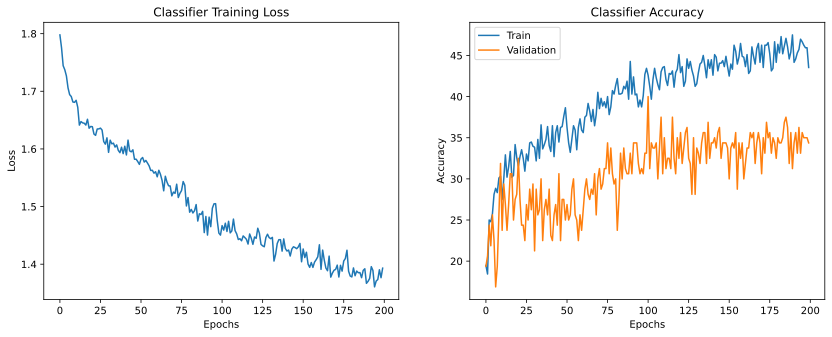

Mean training Accuracy on last 10 epochs:  62.22%
Mean validation Accuracy on last 10 epochs:  54.25%


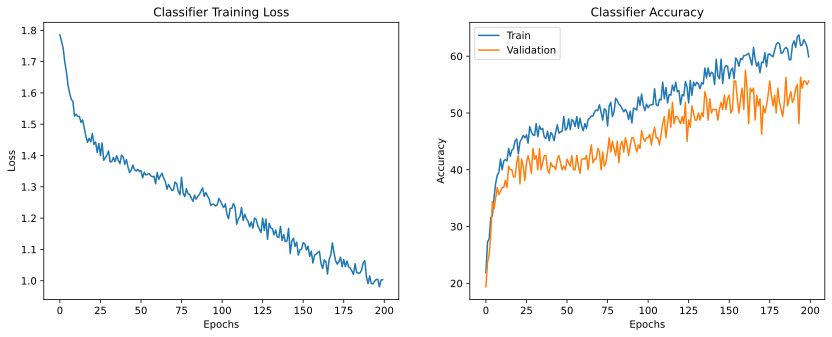

Mean training Accuracy on last 10 epochs:  67.51%
Mean validation Accuracy on last 10 epochs:  44.69%


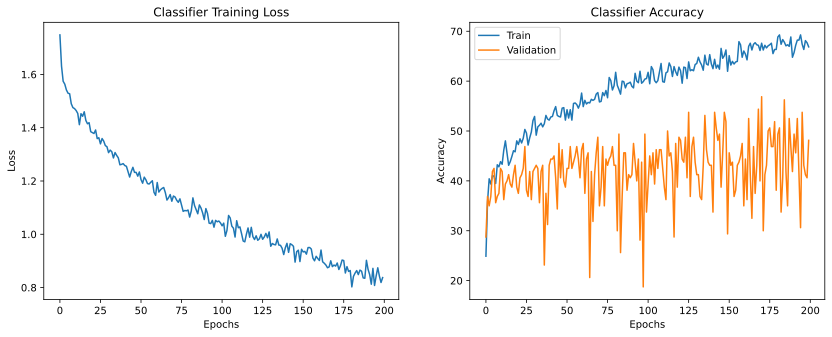

Mean training Accuracy on last 10 epochs:  81.59%
Mean validation Accuracy on last 10 epochs:  65.19%


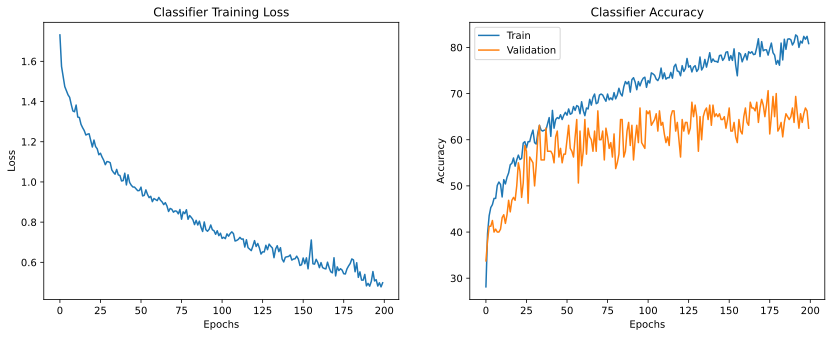

In [134]:
plot_classifier_loss_and_acc(losses_AA, train_acc_AA, val_acc_AA)
plot_classifier_loss_and_acc(losses_BA, train_acc_BA, val_acc_BA)
plot_classifier_loss_and_acc(losses_AB, train_acc_AB, val_acc_AB)       
plot_classifier_loss_and_acc(losses_BB, train_acc_BB, val_acc_BB)

In [ ]:
def load_model_AA(filepath, latent_channels):
    autoencoder, _, _ = create_Autoencoder()
    classifier, _, _ = create_Classifier(latent_channels=latent_channels)
    
    checkpoint = torch.load(filepath, map_location=device)
    autoencoder.encoder.load_state_dict(checkpoint['encoder'])
    classifier.load_state_dict(checkpoint['model_state'])
    
    autoencoder.encoder.eval()
    classifier.eval()
    
    return autoencoder, classifier

def load_model_BA(filepath, latent_channels):
    autoencoder, _, _ = create_ImprovedAutoencoder()
    classifier, _, _ = create_Classifier(latent_channels=latent_channels)
    
    checkpoint = torch.load(filepath, map_location=device)
    autoencoder.encoder.load_state_dict(checkpoint['encoder'])
    classifier.load_state_dict(checkpoint['model_state'])
    
    autoencoder.encoder.eval()
    classifier.eval()
    
    return autoencoder, classifier

def load_model_AB(filepath, latent_channels):
    autoencoder, _, _ = create_Autoencoder()
    classifier, _, _ = create_ImprovedClassifier(latent_channels=latent_channels)
    
    checkpoint = torch.load(filepath, map_location=device)
    autoencoder.encoder.load_state_dict(checkpoint['encoder'])
    classifier.load_state_dict(checkpoint['model_state'])
    
    autoencoder.encoder.eval()
    classifier.eval()
    
    return autoencoder, classifier

def load_model_BB(filepath, latent_channels):
    autoencoder, _, _ = create_ImprovedAutoencoder()
    classifier, _, _ = create_ImprovedClassifier(latent_channels=latent_channels)
    
    checkpoint = torch.load(filepath, map_location=device)
    autoencoder.encoder.load_state_dict(checkpoint['encoder'])
    classifier.load_state_dict(checkpoint['model_state'])
    
    autoencoder.encoder.eval()
    classifier.eval()
    
    return autoencoder, classifier

In [ ]:
ae_AA, clf_AA = load_model_AA('models/model260113_AA.pth', latent_channels=256)
ae_BA, clf_BA = load_model_BA('models/model260113_BA.pth', latent_channels=512)
ae_AB, clf_AB = load_model_AB('models/model260113_AB.pth', latent_channels=256)
ae_BB, clf_BB = load_model_BB('models/model260113_BB.pth', latent_channels=512)

In [ ]:
def sample_test(autoencoder, classifier):
    autoencoder.encoder.eval()
    classifier.eval()
    
    with torch.no_grad():
        images, labels = next(iter(test_loader))
        images = images.to(device)
        latent = autoencoder.encoder(images)
        outputs = classifier(latent)
        _, preds = torch.max(outputs,1)
    print("Predicted classes:", preds.cpu().numpy())
    print("True classes:     ", labels.numpy())


In [ ]:
sample_test(ae_BB, clf_BB)

Predicted classes: [0 1 5 2 3 0 0 2 1 1 2 4 5 5 0 3 2 3 3 2 1 4 0 5 2 0 2 5 4 4 1 5]
True classes:      [0 1 5 2 3 0 0 5 1 1 2 0 5 5 0 3 2 4 4 2 1 2 0 5 0 0 2 5 5 4 0 5]


In [156]:
def show_sample_predictions(autoencoder, classifier, num_images=5):
    autoencoder.eval()
    classifier.eval()
    with torch.no_grad():
        images, labels = random.choice(list(test_loader))
        images = images.to(device)

        latent = autoencoder.encoder(images)
        output = classifier(latent)
        preds = torch.argmax(output, 1)

        images = images.cpu()
        labels = labels.cpu()
        preds = preds.cpu()

    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        
        plt.subplot(2, num_images, i+1)
        plt.imshow(images[i].permute(1,2,0).numpy())
        plt.axis("off")
        true_label = dataset.classes[labels[i].item()]
        pred_label = dataset.classes[preds[i].item()]
        plt.text(
            0.5, -0.20,
            f"Predicted: {pred_label}\n (True: {true_label})",
            fontsize=9,
            ha="center",
            transform=plt.gca().transAxes
        )
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


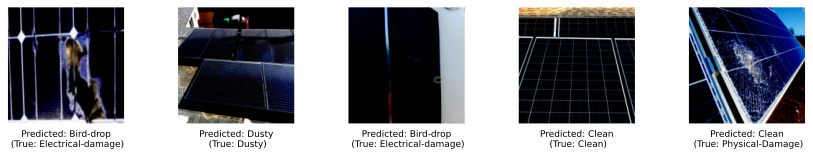

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.58431375..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


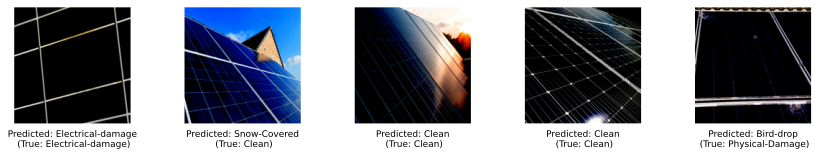

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


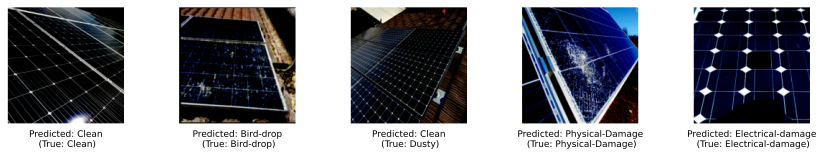

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


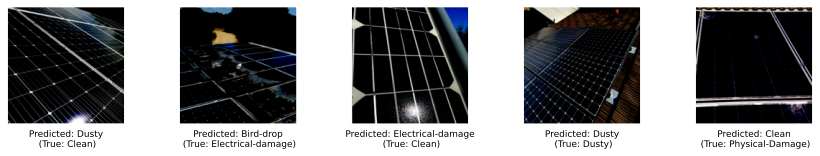

In [150]:
show_sample_predictions(ae_AA, clf_AA)
show_sample_predictions(ae_BA, clf_BA)
show_sample_predictions(ae_AB, clf_AB)
show_sample_predictions(ae_BB, clf_BB)

In [157]:
def evaluate_model(autoencoder, classifier):    
    all_preds = []
    all_labels = []
    test_acc  = []

    autoencoder.encoder.eval()
    classifier.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            latent = autoencoder.encoder(images)
            outputs = classifier(latent)

            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            test_acc.append(100*torch.mean((preds == labels).float()).item())

    print("Test Accuracy: ", f"{np.mean(test_acc):.2f}%")
    cm = confusion_matrix(np.concatenate(all_labels), np.concatenate(all_preds))

    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap='Blues', values_format='d',ax=ax)
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45)
    plt.show()

Test Accuracy:  39.73%


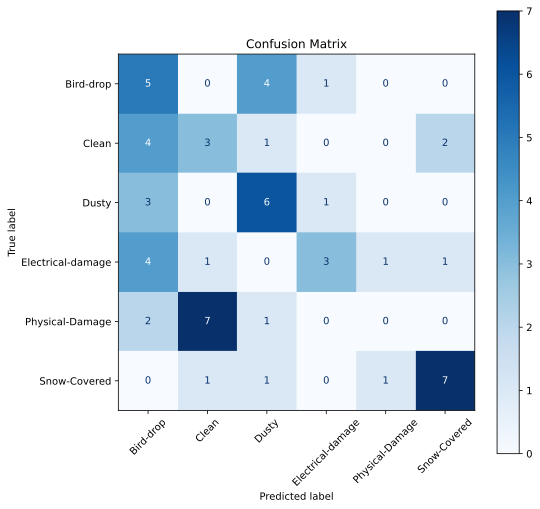

Test Accuracy:  64.73%


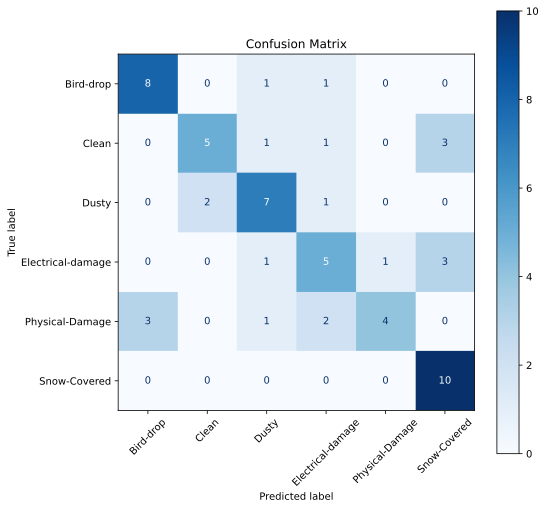

Test Accuracy:  53.57%


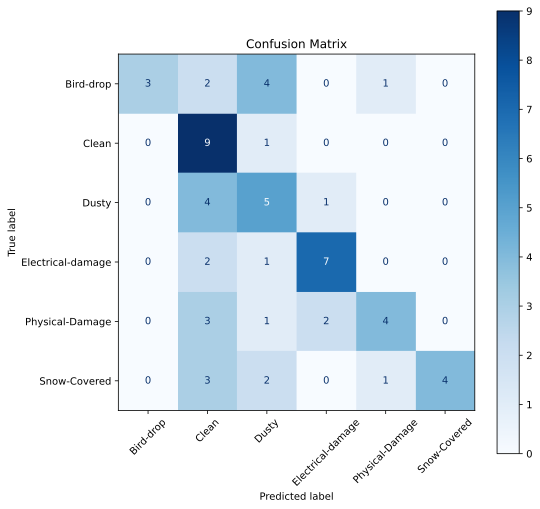

Test Accuracy:  70.54%


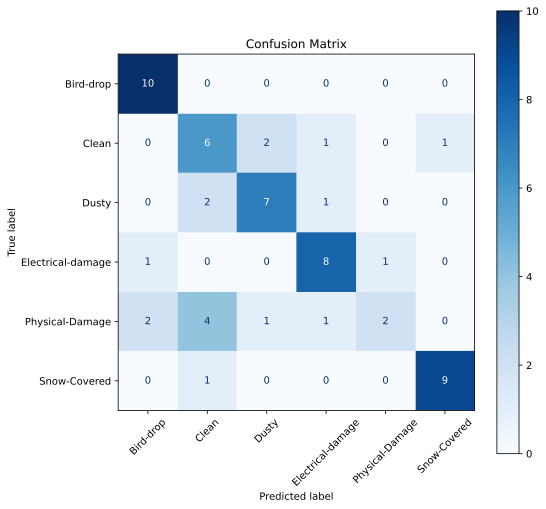

In [158]:
evaluate_model(ae_AA, clf_AA)
evaluate_model(ae_BA, clf_BA)
evaluate_model(ae_AB, clf_AB)
evaluate_model(ae_BB, clf_BB)